# Data analysis coronal hole model

## Import necesarry packages

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from scipy.ndimage import convolve

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

In [2]:
mpl.rcParams["figure.dpi"] = 150    # about the dpi for a 15 inch 1080p laptop, makes sure the displayed plots are the real size 
#mpl.rcParams["figure.dpi"] = 600

mpl.rcParams["figure.figsize"] = (6, 3)
mpl.rcParams["axes.labelsize"] = 12

mpl.rcParams["axes.formatter.limits"] = (-4, 4)

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["xkcd:royal blue", "xkcd:vermillion", "xkcd:orange", 
                                                    "xkcd:magenta", "xkcd:lime", "xkcd:yellow", "grey"])

mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["axes.linewidth"] = .5

mpl.rcParams["font.size"] = 12

mpl.rcParams["text.usetex"] = True


#mpl.rcParams["figure.facecolor"] = "#fffbf0"
#mpl.rcParams["axes.facecolor"] = "#fffbf0"
#mpl.rcParams["savefig.facecolor"] = '#fffbf0'

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

Import metadata about the output such as the time corresponding to each files and conversion factors from code units to physical units

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR = "data/plume-raw-G3/"
OUT_DIR = "data/images/frames/"

# get info about the stored data
file_data = pd.read_csv(DATA_DIR+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

# define the conversion factors
UNIT_DENSITY = 1e9*CONST_mp
UNIT_LENGTH = 1e8 # cm
UNIT_VELOCITY = 1e8 # cm/s

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

## Make plots of the density and pressure to visualize the wave

test with one frame

Reading Data file : data/plume-raw-G3//data.0100.dbl


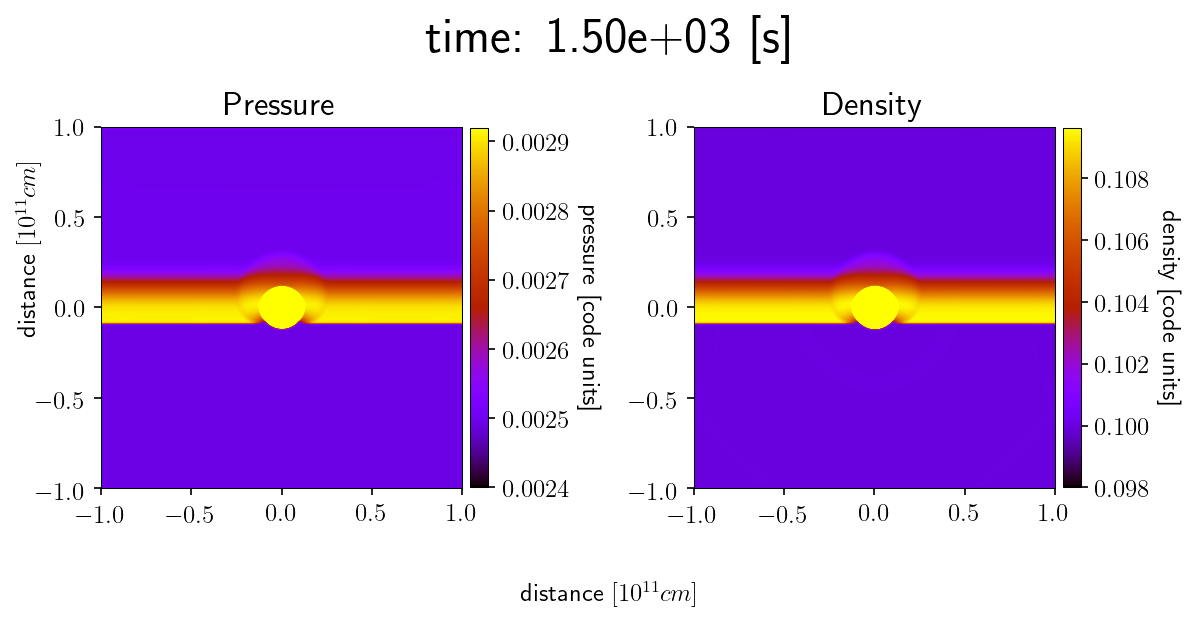

In [5]:
T = file_data["t"].values
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH*1e-11 for value in extent_temp]

def rho_prs(D, i, save=False, name=""):
    fig, ax = plt.subplots(1,2,figsize=(8,4))#figsize=(12.8, 7.2))

    axis = ax[0]
    im=axis.imshow(D.prs, vmin=0.0024, vmax=0.00292, extent=extent, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    cbar.ax.set_ylabel('pressure [code units]', rotation=270, fontsize=12, labelpad=15)
    axis.set_title("Pressure", fontsize=16)

    vmin=0.098
    vmax = 0.10965
    axis = ax[1]
    im=axis.imshow(D.rho, vmin=vmin, vmax=vmax, extent=extent, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    cbar.ax.set_ylabel('density [code units]', rotation=270, fontsize=12, labelpad=15)
    axis.set_title("Density", fontsize=16)


    fig.suptitle("time: %.2e [s]"%(T[i]), y=0.99, fontsize=24)
    #ax.set_xlabel("x-axis [cm]")
    #ax.set_ylabel("y-axis [cm]")

    fig.text(0.5, 0.025, r"distance $[10^{11}cm]$", va='center', ha="center")
    fig.text(0.005, 0.6, r"distance $[10^{11}cm]$", va='center', rotation=90)

    plt.tight_layout()
    
    if save:
        fig.savefig(name)
    
    return fig

i = 100
D = pp.pload(i, w_dir=DATA_DIR+"/")
rho_prs(D, i, save=True, name="test")
plt.show()

Import for each output file the density, plot it and save the output

## Pressure outside and inside plume side by side

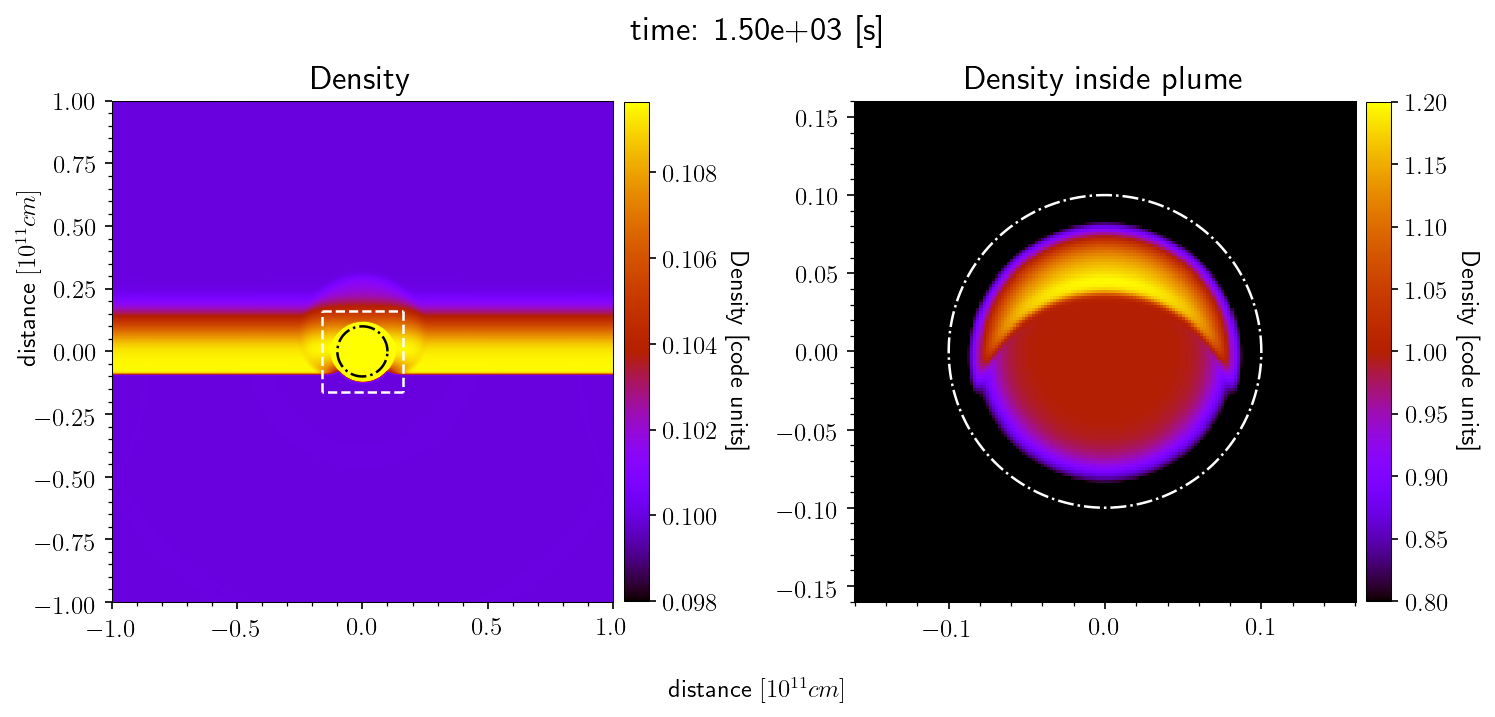

In [6]:
## preparation

T = file_data["t"].values
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH*1e-11 for value in extent_temp]

# region cut out for wave inside of plume
# select region
MIN = 430
MAX = 594
min_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MIN/1024)/(1000)
max_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MAX/1024)/(1000)
# pressure inside plume
ex = [value*UNIT_LENGTH*(MAX-MIN)/1023*1e-11 for value in extent_temp]
# circle of characteristic diameter
d = 100/X_EXTENT[1]
THETA = np.linspace(0,2*np.pi,1000)
X_circ = d*np.cos(THETA)
Y_circ = d*np.sin(THETA)

## end preparation
def plume_zoom(D, i, save=False, name=""):
    fig, ax = plt.subplots(1,2,figsize=(10,5))#(12.8, 7.2))

    # select cutoffs
    vmin=0.098
    vmax = 0.10965

    # pressure outside plume
    axis = ax[0]
    im=axis.imshow(D.rho, vmin=vmin, vmax=vmax, extent=extent, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    cbar.ax.set_ylabel('Density [code units]', rotation=270, fontsize=12, labelpad=15)
    axis.set_title("Density", fontsize=16)
    # draw box of the inset
    axis.plot([min_coord, min_coord], [min_coord, max_coord], "w--", lw=1.2)
    axis.plot([min_coord, max_coord], [max_coord, max_coord], "w--", lw=1.2)
    axis.plot([max_coord, max_coord], [max_coord, min_coord], "w--", lw=1.2)
    axis.plot([max_coord, min_coord], [min_coord, min_coord], "w--", lw=1.2)
    # draw the circle of characteristic width for the plume/hole
    axis.plot(X_circ,Y_circ,"-.k",lw=1.2)
    # small ticks
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())


    # select cutoffs
    if (i < 115) or (i > 135):
        vmin = 0.8
        vmax = 1.2
    else:
        vmin = 0.8 - 1/121*1/10*(i-114)*(136-i)
        vmax = 1.2 + 1/121*3/10*(i-114)*(136-i)

    # pressure inside plume
    axis = ax[1]
    im=axis.imshow(D.rho[MIN:MAX,MIN:MAX], vmin=vmin, vmax=vmax, extent=ex, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    cbar.ax.set_ylabel('Density [code units]', rotation=270, fontsize=12, labelpad=15)
    axis.set_title("Density inside plume", fontsize=16)
    axis.plot(X_circ,Y_circ,"-.w",lw=1.2)
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())


    fig.suptitle("time: %.2e [s]"%(T[i]), y=0.95, fontsize=16)
    #ax.set_xlabel("x-axis [cm]")
    #ax.set_ylabel("y-axis [cm]")

    fig.text(0.5, 0.05, r"distance $[10^{11}cm]$", va='center', ha="center")
    fig.text(0.005, 0.6, r"distance $[10^{11}cm]$", va='center', rotation=90)

    plt.tight_layout()
    
    if save:
        fig.savefig(name)

    return fig

plume_zoom(D,i)
plt.show()

In [7]:
X = np.linspace(X_EXTENT[0], X_EXTENT[1], X_POINTS)
ref = pp.pload(0, DATA_DIR)
SECTION = int(1/2*X_POINTS)

def sections(D, i, save=False, name=""):
    fig, ax = plt.subplots(3,1, figsize=(6,6))

    # find the front of the wave
    large = (D.rho[:,0]/ref.rho[:,0])>1.05 # the large excitations
    indexes = np.where(large == 1)
    try:
        index = indexes[0][-1]
        physical_position = X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*index/X_POINTS
    except:
        physical_position = X_EXTENT[1]

    # outside
    axis = ax[0]
    axis.set_ylim(0.097,0.11)
    axis.plot(X, D.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.get_xaxis().set_visible(False)
    axis.set_ylabel(r"density [$10^9 cm^{-3}$]")
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    # relative
    axis = ax[1]
    axis.plot(X, D.rho[:,SECTION]/ref.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.set_ylim(-0.2,2)
    axis.set_title("relative change in density with respect to initial condition")
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    # inside
    axis = ax[2]
    axis.plot(X, D.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.set_ylim(0.8,1.5)
    axis.set_xlim(-150,150)
    axis.set_ylabel(r"density [$10^8 cm^{-3}$]")
    axis.set_xlabel(r"distance [$10^{11}$ cm]")
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    fig.suptitle("time: %.2e [s]"%T[i], y=1)
    plt.tight_layout()
    
    if save:
        fig.savefig(name)
    
    return fig

#sections(D, i)
#plt.show()

Reading Data file : data/plume-raw-G3/data.0000.dbl


## plots for every snapshot

In [9]:
# initialize names to save the plots under
NAME_PRS_RHO = "data/images/both/frame"
NAME_ZOOM = "data/presentation/zoom/frame"
NAME_SECTION = "data/images/section/section%04iframe"%SECTION

### initialization "both"
#-----------------------------
T = file_data["t"].values
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH*1e-11 for value in extent_temp]

### initialization "zoom"
#-----------------------------
ex = [value*UNIT_LENGTH*(MAX-MIN)/1023*1e-11 for value in extent_temp]

# region cut out for wave inside of plume
# select region
MIN = 430
MAX = 594
min_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MIN/1024)/(1000)
max_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MAX/1024)/(1000)
# circle of characteristic diameter
d = 100/X_EXTENT[1]
THETA = np.linspace(0,2*np.pi,1000)
X_circ = d*np.cos(THETA)
Y_circ = d*np.sin(THETA)

### initialization "section"
#------------------------------
X = np.linspace(X_EXTENT[0], X_EXTENT[1], X_POINTS)
ref = pp.pload(0, DATA_DIR)
SECTION = int(1/2*X_POINTS)


### loop over all data
for i in range(100,200):
    # read the data
    D = pp.pload(i, w_dir=DATA_DIR)
    # make the plot of both variables
    #fig = rho_prs(D, i, save=True, name=NAME_PRS_RHO + "%03i.png"%i)
    #fig.savefig(NAME_PRS_RHO + "%03i.png"%i)
    #plt.close(fig=fig)
    # make the plot for the zoom
    fig = plume_zoom(D, i, save=True, name=NAME_ZOOM + "%03i.png"%i)
    #fig.savefig(NAME_ZOOM + "%03i.png"%i)
    plt.close(fig=fig)
    # make the plot for the section
    #fig = sections(D, i, save=True, name=NAME_SECTION + "%03i.png"%i)
    #fig.savefig(NAME_SECTION + "%03i.png"%i)
    #plt.close(fig=fig)

Reading Data file : data/plume-raw-G3/data.0000.dbl
Reading Data file : data/plume-raw-G3/data.0100.dbl
Reading Data file : data/plume-raw-G3/data.0101.dbl
Reading Data file : data/plume-raw-G3/data.0102.dbl
Reading Data file : data/plume-raw-G3/data.0103.dbl
Reading Data file : data/plume-raw-G3/data.0104.dbl
Reading Data file : data/plume-raw-G3/data.0105.dbl
Reading Data file : data/plume-raw-G3/data.0106.dbl
Reading Data file : data/plume-raw-G3/data.0107.dbl
Reading Data file : data/plume-raw-G3/data.0108.dbl
Reading Data file : data/plume-raw-G3/data.0109.dbl
Reading Data file : data/plume-raw-G3/data.0110.dbl
Reading Data file : data/plume-raw-G3/data.0111.dbl
Reading Data file : data/plume-raw-G3/data.0112.dbl
Reading Data file : data/plume-raw-G3/data.0113.dbl
Reading Data file : data/plume-raw-G3/data.0114.dbl
Reading Data file : data/plume-raw-G3/data.0115.dbl
Reading Data file : data/plume-raw-G3/data.0116.dbl
Reading Data file : data/plume-raw-G3/data.0117.dbl
Reading Data